# Интерполяция Чебышева для решения задачи $1 | r_j | L_{max}$

### Импорты

In [1]:
import json
import time
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### Алгоритм решения задачи $1|r_j|L_{max}$
Для ускорения вычислений использован **таймаут:** если алгоритм не решает задачу за 2 минуты - он автоматически переходит к следующей.

In [2]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return TaskSet([]), -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if max(i.nu, N[i.pi].L_max(tau)) < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        

### Парсинг "сложных" примеров

In [3]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=float)
    s = s.reshape((len(s)//3, 3))
    return s

schedules = []
for fname in glob.glob("./tasks/*.txt"):
    file = open(fname, 'r')
    a = np.array(list(f.split() for f in file.readlines()[:-2])).astype(float)
    schedules.append(TaskSet(a))

# Прямая в n-мерном пространстве

### Уравнение прямой в n-мерном пространстве:
$\frac{x - x_1}{x_2 - x_1} = \frac{y - y_1}{y_2 - y_1} = ...$

In [6]:
def linear_equation(x, x1, x2):
    return (x - x1) / (x2 - x1)

### Проверка выполнения уравнения для всех точек ("сложные" примеры)

In [8]:
for n, s in enumerate(schedules):
    scaledSchedules = []
    #s = TaskSet(10)
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    pointResults = []
    s1, s2 = flattenedScaledSchedules[:2]
    for s in flattenedScaledSchedules[2:]:
        linearEqResults = []
        for index, x1 in enumerate(s1):
            x2 = s2[index]
            x = s[index]
            if x2 != x1: linearEqResults.append(linear_equation(x, x1, x2))
        pointResults.append(np.all(np.isclose(linearEqResults, linearEqResults[0])))
    print("В примере %s все точки - на одной прямой:" % n, np.all(pointResults))

В примере 0 все точки - на одной прямой: True
В примере 1 все точки - на одной прямой: True
В примере 2 все точки - на одной прямой: True
В примере 3 все точки - на одной прямой: True
В примере 4 все точки - на одной прямой: True
В примере 5 все точки - на одной прямой: True
В примере 6 все точки - на одной прямой: True
В примере 7 все точки - на одной прямой: True
В примере 8 все точки - на одной прямой: True
В примере 9 все точки - на одной прямой: True


### Проверка выполнения уравнения для всех точек (5000 случайно сгенерированных примеров)

In [11]:
N_TASKS = 5000
res = 0

prgBar = IntProgress(min = 0, max = N_TASKS)
display(prgBar)
for n in range(N_TASKS):
    scaledSchedules = []
    s = TaskSet(10)
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    pointResults = []
    s1, s2 = flattenedScaledSchedules[:2]
    for s in flattenedScaledSchedules[2:]:
        linearEqResults = []
        for index, x1 in enumerate(s1):
            x2 = s2[index]
            x = s[index]
            if x2 != x1: linearEqResults.append(linear_equation(x, x1, x2))
        pointResults.append(np.all(np.isclose(linearEqResults, linearEqResults[0])))
    if np.all(pointResults): res += 1
    prgBar.value += 1
print("Все точки на одной прямой в %s %% примеров" % (100*res/N_TASKS))

IntProgress(value=0, max=5000)

Все точки на одной прямой в 100.0 % примеров


# Интерполирование

In [117]:
global approxResults
global realResult
def test_schedule(alpha_arr):
    errorFlag = True
    global approxResults
    global realResult
    while errorFlag:
        errorFlag = False
        approxResults = []
        s = TaskSet(10)
        for a in alpha_arr:
            print("\ra =", a, end='')
            scaled_s = s.copy().scale_r(a)
            #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
            bestPi, bestCounter = main(scaled_s, verbose=False)
            Lmax = scaled_s[bestPi].L_max()
            #print("\rL_max =", Lmax, end='')
            if Lmax == float('inf'):
                errorFlag = True
                break
            approxResults.append((a, Lmax))
        bestPi, bestCounter = main(s)
        realResult = (1., s[bestPi].L_max())
        approxResults = np.array(approxResults)
    return approxResults[:,1]

## Результаты интерполирования: графики зависимости значения ЦФ от коэф-та $\alpha$ в преобразовании $r'_j = \alpha r_j$
(12 случайно сгенерированных примеров)

IntProgress(value=0, max=12)

a = 1.993712209893242746

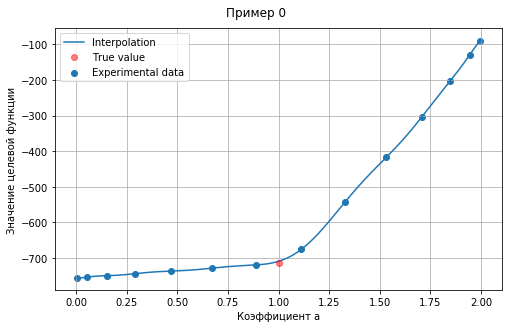

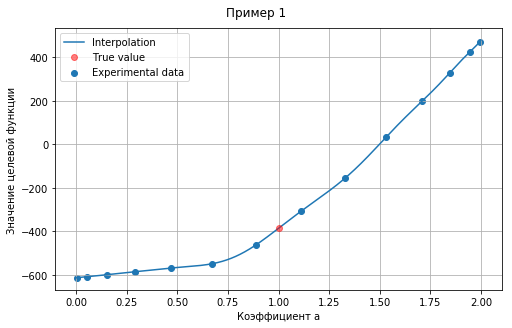

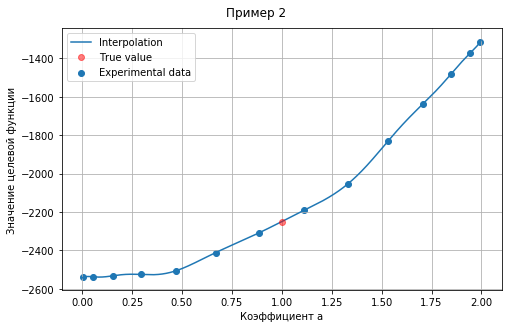

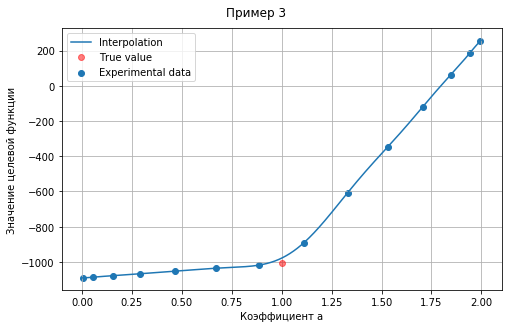

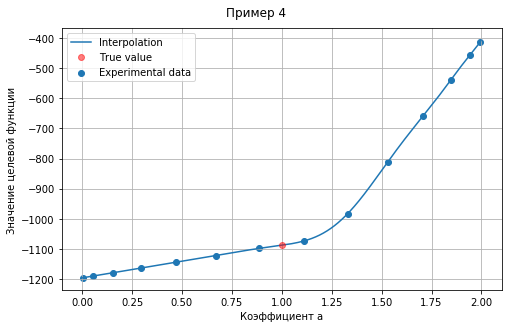

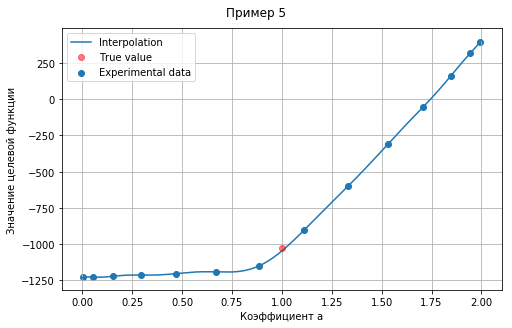

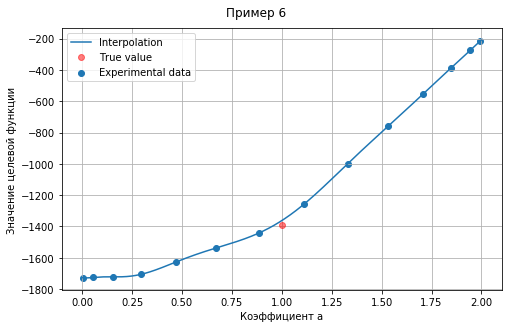

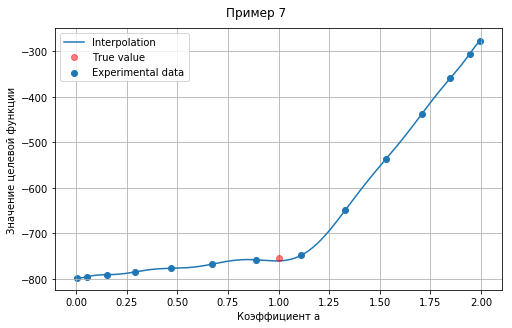

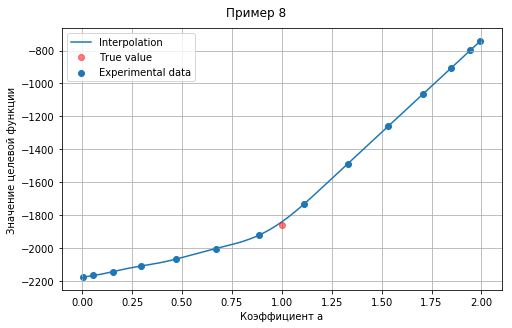

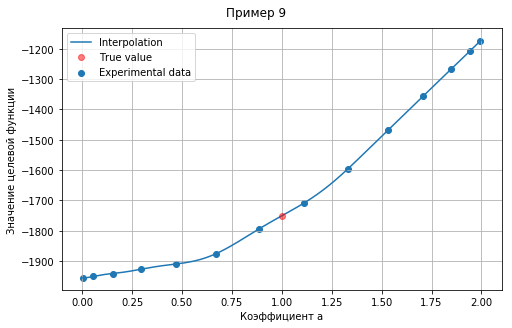

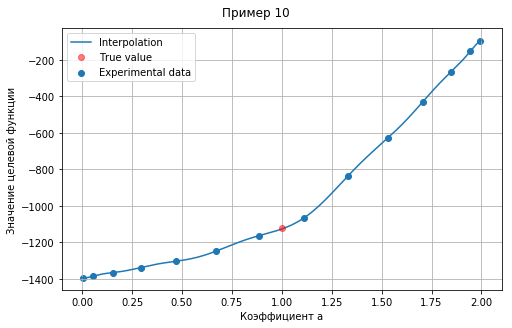

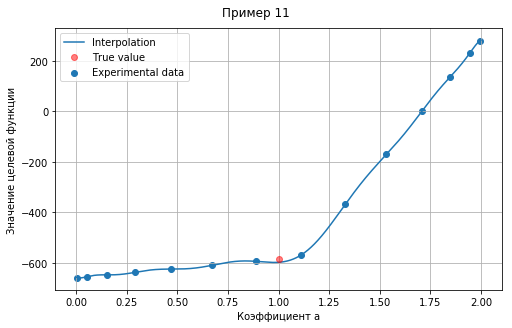

In [118]:
N_TASKS = 12
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
for i in range(N_TASKS):
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    approxResults = np.array(approxResults)
    
    x = approxResults[:,0]
    y = approxResults[:,1]
    xp = np.arange(0, 2, 0.001)
    yp = C(xp)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Пример %s" % i)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
    axes.legend()
    pBar.value += 1

### Анализ результатов и ошибок для 200 случайных примеров
Для каждого примера: точное значение целевой функции в точке $\alpha = 1$ сравнивается с аппроксимированным. Результаты - в таблице ниже

In [122]:
N_TASKS = 200
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
results = []
for i in range(N_TASKS):
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    results.append((C(1.) - realResult[1])/realResult[1]*100)
    pBar.value += 1
with open("ChebyshevEfficiencyResults.json", 'w') as f:
    json.dump(results, f)

IntProgress(value=0, max=200)

a = 1.993712209893242746 1.1119644761033078 1.1119644761033078 0.8880355238966922 1.1119644761033078 0.29289321881345254 0.056116669691632426 0.8880355238966922 1.5320320765153366 0.46796792348466354 1.1119644761033078

In [127]:
with open("ChebyshevEfficiencyResults.json", 'r') as f:
    results = json.load(f)
pd.DataFrame([[max(np.abs(results)), min(np.abs(results)), np.mean(np.abs(results)), np.mean(results)]], columns=["Максимум модуля отклонения, %", "Минимум модуля отклонения, %", "Средний модуль отклонения, %", "Среднее отклонение, %"])

,"Максимум модуля отклонения, %","Минимум модуля отклонения, %","Средний модуль отклонения, %","Среднее отклонение, %"
0,137.318625,8.262835e-14,1.931797,-0.282652


# Итоги и выводы
- Интерполяция Чебышева показала результаты лучше, чем интерполяция Лагранжа, используя при этом меньшее кол-во точек.
- Минус интерполяции Чебышева - невозможность выбирать узлы интерполяции произвольно.
- Исследование можно продолжить, проанализировав выигрыш в производительности благодаря изучаемой методике.